In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import nltk
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize
import contractions
import time
import string
import re
import inspect
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train.csv', header=0)

### 1. Null Imputation

In [3]:
# Here we are handeling null values by replacing with empty space 
# and removing whitespaces from 'text' column.


train_df = train_df.fillna(' ')
train_df['text'] = train_df['text'].str.strip()
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length']==0]))
train_df.head()

116


,id,title,author,text,label,raw_text_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938


In [4]:
train_df = train_df[train_df['raw_text_length'] > 0]
train_df.shape

(20684, 6)

### 2. Data Preprocessing
##### 1.Remove special characters
##### 2. Expand contractions
##### 3. Convert to lower-case
##### 4. Word Tokenize
##### 5. Remove Stopwords

In [5]:
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        try:
            word_list.append(contractions.fix(each_word).lower())
        except:
            print(x)
    return " ".join(word_list)

In [6]:
text_cols = ['text', 'title', 'author']

In [7]:
#Time taken by preprocess_text function

%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))

Wall time: 0 ns
Processing column: text
Processing column: title
Processing column: author


In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [9]:
%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(word_tokenize)

Wall time: 0 ns
Processing column: text
Processing column: title
Processing column: author


In [10]:
train_df.head()

,id,title,author,text,label,raw_text_length
0,0,"[house, dem, aide, we, did, not, even, see, co...","[darrell, lucus]","[house, dem, aide, we, did, not, even, see, co...",1,4930
1,1,"[flynn, hillary, clinton, big, woman, on, camp...","[daniel, j, flynn]","[ever, get, the, feeling, your, life, circles,...",0,4160
2,2,"[why, the, truth, might, get, you, fired]",[consortiumnewscom],"[why, the, truth, might, get, you, fired, octo...",1,7692
3,3,"[15, civilians, killed, in, single, us, airstr...","[jessica, purkiss]","[videos, 15, civilians, killed, in, single, us...",1,3237
4,4,"[iranian, woman, jailed, for, fictional, unpub...","[howard, portnoy]","[print, an, iranian, woman, has, been, sentenc...",1,938


In [11]:
%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])

Wall time: 0 ns
Processing column: text
Processing column: title
Processing column: author


### Model Training

In [12]:
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
target = train_df['label'].values

In [13]:
train_df.head()

,id,title,author,text,label,raw_text_length,text_joined
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930,house dem aide even see comeys letter jason ch...
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160,ever get feeling life circles roundabout rathe...
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692,truth might get fired october 29 2016 tension ...
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237,videos 15 civilians killed single us airstrike...
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938,print iranian woman sentenced six years prison...


In [14]:
# This process is called feature extraction (or vectorization). 
# Scikit-learn's CountVectorizer is used to convert a 
# collection of text documents to a vector of term/token counts.

count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tf_idf_transformer = TfidfTransformer(smooth_idf=False)

# fit train data to count vectorizer
count_vectorizer.fit(train_df['text_joined'].values)
count_vect_train = count_vectorizer.transform(train_df['text_joined'].values)

# fit ngrams count to tfidf transformers
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

### Train Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target,test_size = 0.2, stratify=target, random_state=2)

In [16]:
df_perf_metrics = pd.DataFrame(columns=['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])

### Machine Learning Classifier Training and Validating

In [17]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set','Precision','Recall','f1_score','Training Time(secs)','Parameters'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    paramsArr=["class_weight='balanced',solver='saga'","min_samples_split=4","C=2.0","alpha=2.0","max_depth=2.0"]
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    confusion_matrix(y_test,y_pred,labels=[1,0])
    
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time),
        paramsArr[i]
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [18]:
models_list = [LogisticRegression(class_weight='balanced',solver='saga'),
               DecisionTreeClassifier(min_samples_split=4),
               LinearSVC(C=2.0),
               MultinomialNB(alpha=2.0),
               RandomForestClassifier(max_depth=2.0)
               ]

In [19]:
%time
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Wall time: 0 ns
Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 19.38 s.
Completed LogisticRegression model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 434.05 s.
Completed DecisionTreeClassifier model's performance assessment.
Training LinearSVC model...
Completed LinearSVC model training.
Time elapsed: 5.68 s.
Completed LinearSVC model's performance assessment.
Training MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.72 s.
Completed MultinomialNB model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 9.31 s.
Completed RandomForestClassifier model's performance assessment.


In [20]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time(secs),Parameters
0,LogisticRegression,0.983441,0.944888,0.929611,0.962118,0.945585,19.38,"class_weight='balanced',solver='saga'"
1,DecisionTreeClassifier,0.999275,0.898235,0.890744,0.906751,0.898676,434.05,min_samples_split=4
2,LinearSVC,0.999940,0.961566,0.950237,0.973774,0.961861,5.68,C=2.0
3,MultinomialNB,0.899257,0.788011,0.997475,0.575522,0.729905,0.72,alpha=2.0
4,RandomForestClassifier,0.748776,0.733382,0.732264,0.731909,0.732086,9.31,max_depth=2.0


In [21]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

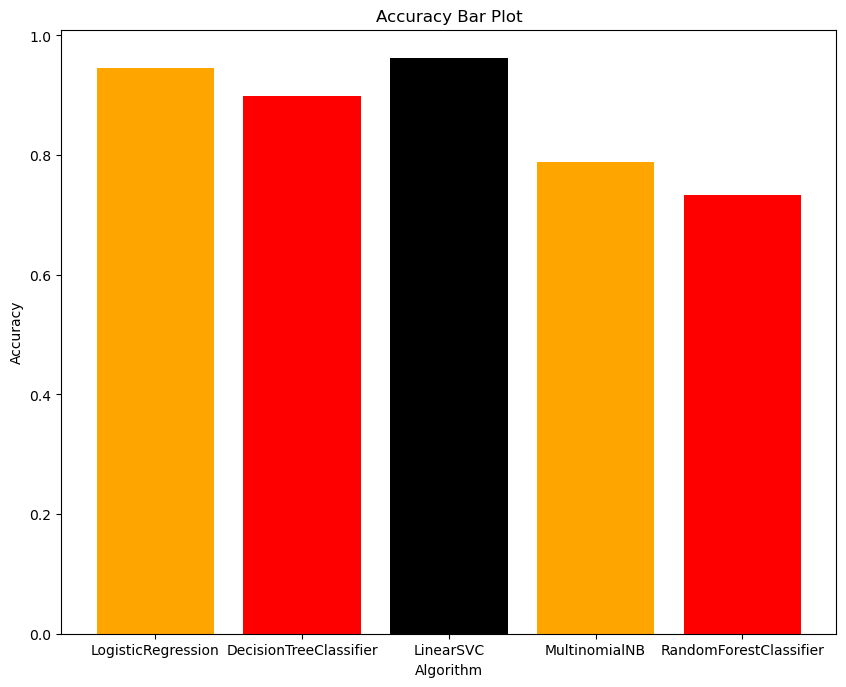

In [22]:
plt.bar(df_perf_metrics['Model'],df_perf_metrics['Accuracy_Test_Set'],color=['orange', 'red', 'black'])
plt.xlabel('Algorithm')
plt.ylabel("Accuracy")
plt.title('Accuracy Bar Plot')
plt.show()

In [23]:
model = models_list[2]
filename = 'finalize_model.pkl'
pickle.dump(model,open(filename,'wb'))